In [1]:
import warnings
warnings.filterwarnings("ignore")

from src.acquire import get_zillow_data
from src.prepare import wrangle_zillow, geo_df, split_data
from src.sklearn24 import mean_absolute_percentage_error

import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

lucario = ['#6EA4BB', '#C04C4B', '#464646', '#E7E7E6', '#F0DBA5']
sns.set_palette(sns.color_palette(lucario))

import geopandas as gpd
from shapely.geometry import Point, Polygon

from sklearn.feature_selection import SelectKBest, f_regression, RFE

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, RobustScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.pipeline import make_pipeline

import eli5

[Modeling](#2)

In [7]:
#df = get_zillow_data()
#df.to_csv("data/sfr_2017.csv")

df = pd.read_csv("data/sfr_2017.csv", index_col=0)
X_train, X_test, X_val, y_train, y_test, y_val = wrangle_zillow(df, k=2.5) #k specifies outlier clipping
X_train.info()

X_train, X_test, X_val, y_train, y_test, y_val
(23857, 401) (5113, 401) (5113, 401) (23857,) (5113,) (5113,)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 23857 entries, 28885 to 26066
Columns: 401 entries, bathroomcnt to 399675
dtypes: float64(5), int64(9), object(1), uint8(386)
memory usage: 11.7+ MB


In [3]:
X_train.county.value_counts()

Los Angeles    14519
Orange          7123
Ventura         2215
Name: county, dtype: int64

In [4]:
y_train.describe()

count    2.385700e+04
mean     4.053830e+05
std      2.554131e+05
min      7.771000e+03
25%      2.159960e+05
50%      3.588800e+05
75%      5.389650e+05
max      1.497493e+06
Name: taxvalue, dtype: float64

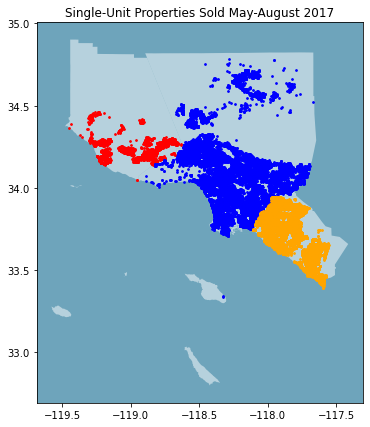

In [5]:
#https://gisdata-scag.opendata.arcgis.com/datasets/county-boundaries-scag-region/explore?filters=eyJBQ1JFUyI6WzY4Ny40OTYwMjEyOCwyNzUwNTIyLjMyXX0%3D&location=34.131659%2C-116.867850%2C7.00
file = 'data/County_Boundaries/County_Boundaries_%E2%80%93_SCAG_Region.shp'
geo_df, map_ = geo_df(X_train, y_train, file)

f, ax = plt.subplots(figsize=(11,7))
ax.set_facecolor(lucario[0])
map_.plot(ax=ax, alpha=.5, color='white')

geo_df[geo_df.county=='Ventura'].plot(ax=ax, markersize=3, color='red', label="Ventura")
geo_df[geo_df.county=='Los Angeles'].plot(ax=ax, markersize=3, color='blue', label="L.A.")
geo_df[geo_df.county=='Orange'].plot(ax=ax, markersize=3, color='orange', label="Orange")

plt.title("Single-Unit Properties Sold May-August 2017");
plt.savefig('img/geodf.png');

<img src="img/socal.png" width=300px>

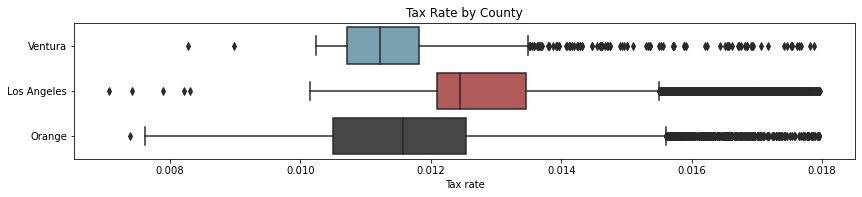

In [12]:
counties = ["Ventura", "Los Angeles", "Orange"]

plt.figure(figsize=(14, 2.5))
sns.boxplot(data=X_train, y='county', x='taxrate', order=counties)
plt.ylabel("")
plt.xlabel("Tax rate")
plt.title("Tax Rate by County")
plt.show()

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


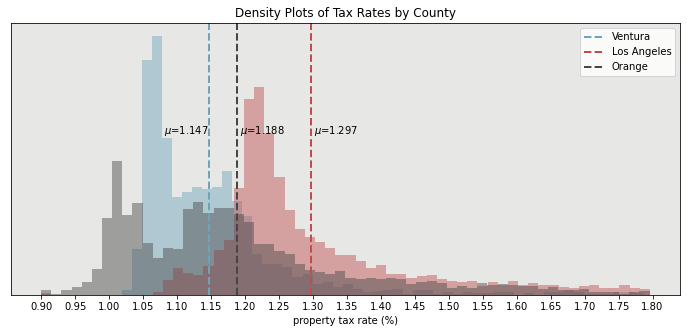

In [13]:
f, ax = plt.subplots(figsize=(12,5))
for i, county in enumerate(counties):
    ax.set_facecolor(lucario[3])
    plt.title("Density Plots of Tax Rates by County")
    plt.xlabel("property tax rate (%)")
    #so bins are the same width
    clipped = X_train.taxrate[X_train.county==county].clip(.009, .018)*100
    plt.axvline(clipped.mean(), color=lucario[i], linestyle='dashed', linewidth=2)
    
    la_mean = np.round(clipped[X_train.county=='Los Angeles'].mean(),3)
    ve_mean = np.round(clipped[X_train.county=='Ventura'].mean(),3)
    or_mean = np.round(clipped[X_train.county=='Orange'].mean(),3)
    plt.text(.004+la_mean, 6, f'$\mu$={la_mean}')
    plt.text(.004+or_mean, 6, f'$\mu$={or_mean}')
    plt.text(-.066+ve_mean, 6, f'$\mu$={ve_mean}')

    clipped.hist(bins=60, alpha=.45, density=True)
    plt.xticks(np.linspace(.9,1.8,19))
    plt.yticks([])
    plt.grid(False)
plt.legend(counties)
plt.savefig('img/taxrates.png')

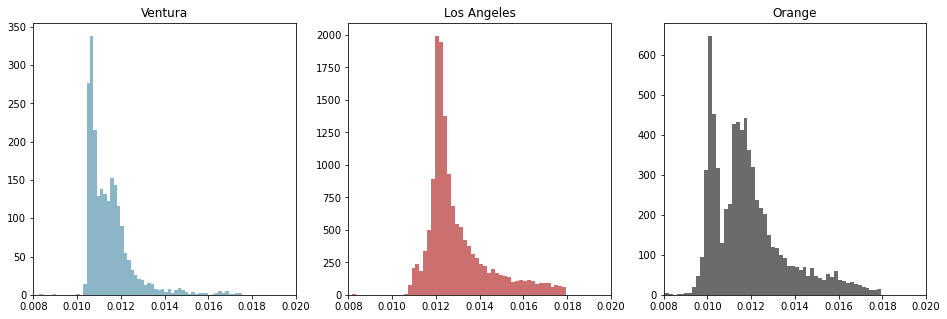

In [19]:
counties = ["Ventura", "Los Angeles", "Orange"]
plt.figure(figsize=(16,5))
for i, county in enumerate(counties):
    plot_number = i + 1 
    plt.subplot(1, len(counties), plot_number)
    plt.title(county)
    plt.xlim(.008, .02)
    X_train.taxrate[X_train.county==county].hist(bins=60, alpha=.8, color=lucario[i])
    plt.grid(False)

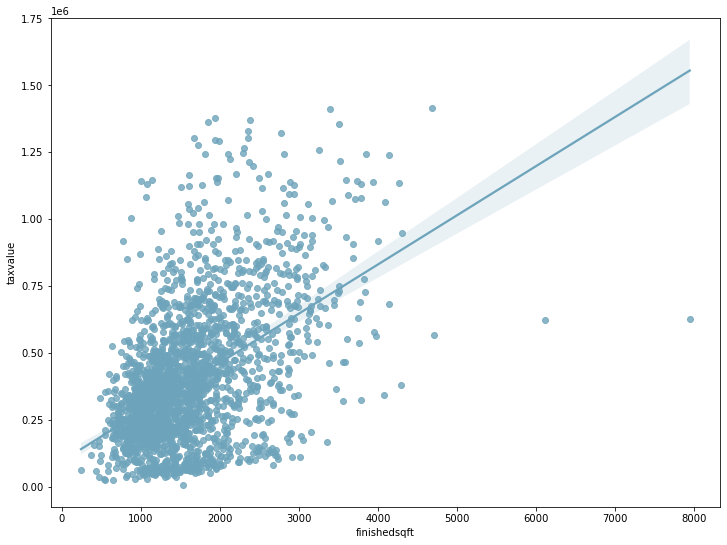

In [24]:
#heteroskedasticity
plt.figure(figsize=(12,9))
sns.regplot(data=X_train[:2100], x="finishedsqft", y="taxvalue", robust=True);

## Hypotheses

H<sub>0</sub> Home values are independent of county.

H<sub>0</sub> Home values do not have a linear relationship with living-area ratio.

<a id='2'></a>
## Modeling

Zillow Prize FAQ:

Why did Zillow pick the log error instead of an absolute error metric such as RMSE?

Home sale prices have a **right skewed distribution** and are also **strongly heteroscedastic**, so **we need to use a relative error metric instead of an absolute metric** to ensure valuation models are not biased towards expensive homes. A relative error metric like the percentage error or log ratio error avoids these problems. While we report Zestimate errors in terms of percentages on Zillow.com because we believe that to be a more intuitive metric for consumers, we do not advocate using percentage error to evaluate models in Zillow Prize, as it may lead to biased models The log error is free of this bias problem and when using the natural logarithm, errors close to 1 approximate percentage errors quite closely.

https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2635088

Now that we’ve identified the presence of heteroskedasticity in our data, what can we do about it? Recall that the two main consequences of heteroskedasticity are 1) ordinary least squares no longer produces the best estimators and 2) standard errors computed using least squares can be incorrect and misleading. Let’s first deal with the issue of incorrect standard errors.

When heteroskedasticity is present, the best linear unbiased estimator depends on the uknown σ2i. This estimator is referred to as the generalized least squares estimator. 

Let’s assume that the data is heteroskedastic and that we know the nature of the heteroskedasticity. We can then define sigma and use it to give us a GLS model

Heteroskedasticity occurs when the variance for all observations are not the same. To detect heteroskedasticity, one can plot the least squares residuals ê i against the independent variable xi (or ŷ i if it’s a multiple regression model). If there is an distinguishable pattern, then heteroskedasticity might be present. 

In [65]:
def rfe(X, y, k):
    """takes in the predictors, the target, and the number of features to select.
    and return the top k features based on the RFE class."""
    rfe = RFE(LinearRegression(), k)
    X_rfe = rfe.fit_transform(X, y)
    
    mask = rfe.support_
    rfe_features = X.loc[:, mask].columns.tolist()
    
    print(str(len(rfe_features)), 'selected features')
    print(rfe_features)

def select_kbest(X, y, k):
    """takes in the predictors (X), the target (y), and the number of features to select (k)
    and returns the names of the top k selected features based on the SelectKBest class."""
    # parameters: f_regression stats test, give me 8 features
    f_selector = make_pipeline(StandardScaler(), SelectKBest(f_regression, k=k))
    f_selector.fit(X, y)

    # boolean mask of whether the column was selected or not. 
    feature_mask = f_selector[1].get_support()

    # get list of top K features. 
    f_feature = X_train.iloc[:,feature_mask].columns.tolist()
    
    print(str(len(f_feature)), 'features')
    print(f_feature)

In [66]:
k=5
select_kbest(X_train, y_train, k=k)

5 features
['bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid', 'finishedsqft', 'livingarearatio']


In [67]:
y_pred = np.zeros((len(y_train),)) + y_train.mean()
print("Evaluating the Mean Model (in sample):")
print(f"  RMSE: {int(np.round(mean_squared_error(y_train, y_pred, squared=False),-3))}")
print(f"  MAPE: {np.round(mean_absolute_percentage_error(y_train, y_pred),2)}")
print(f"  R^2: {np.round(r2_score(y_train, y_pred),2)}")
y_pred = np.zeros((len(y_val),)) + y_train.mean()
print("Evaluating the Mean Model (out of sample):")
print(f"  RMSE: {int(np.round(mean_squared_error(y_val, y_pred, squared=False),-3))}")
print(f"  MAPE: {np.round(mean_absolute_percentage_error(y_val, y_pred),2)}")
print(f"  R^2: {np.round(r2_score(y_val, y_pred),2)}")

Evaluating the Mean Model (in sample):
  RMSE: 255000
  MAPE: 0.94
  R^2: 0.0
Evaluating the Mean Model (out of sample):
  RMSE: 256000
  MAPE: 0.91
  R^2: -0.0


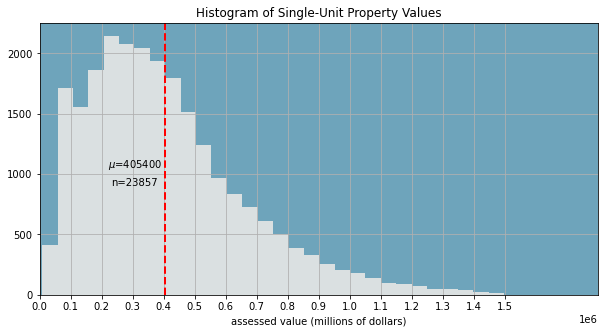

In [8]:
f, ax = plt.subplots(figsize=(10,5))
ax.set_facecolor(lucario[0])
plt.title("Histogram of Single-Unit Property Values")
plt.xlabel("assessed value (millions of dollars)")
plt.xlim(0, 1.8e6)
plt.axvline(y_train.mean(), color='red', linestyle='dashed', linewidth=2)
plt.xticks(np.linspace(0,1.5e6,16))
plt.text(2.2e5, 1050, f'$\mu$={int(np.round(y_train.mean(),-2))}')
#plt.text(2.2e5, 900, f'$\sigma$={int(np.round(y_train.std(),-2))}')
plt.text(2.3e5, 900, f'n={len(y_train)}')

y_train.hist(bins=30, alpha=.9, color=lucario[3])
plt.savefig('img/meanhist.png')

In [9]:
xvars = ['bedroomcnt', 'finishedsqft']
reg = LinearRegression().fit(X_train[xvars], y_train)
y_pred = reg.predict(X_train[xvars])

print("Evaluating the MVP Model (in sample):")
print(f"  RMSE: {int(np.round(mean_squared_error(y_train, y_pred, squared=False),-3))}")
print(f"  MAPE: {np.round(mean_absolute_percentage_error(y_train, y_pred),2)}")
print(f"  R^2: {np.round(r2_score(y_train, y_pred),2)}")

y_pred = reg.predict(X_val[xvars])

print("Evaluating the MVP Model (out of sample):")
print(f"  RMSE: {int(np.round(mean_squared_error(y_val, y_pred, squared=False),-3))}")
print(f"  MAPE: {np.round(mean_absolute_percentage_error(y_val, y_pred),2)}")
print(f"  R^2: {np.round(r2_score(y_val, y_pred),2)}")

Evaluating the MVP Model (in sample):
  RMSE: 221000
  MAPE: 0.78
  R^2: 0.25
Evaluating the MVP Model (out of sample):
  RMSE: 225000
  MAPE: 0.78
  R^2: 0.23


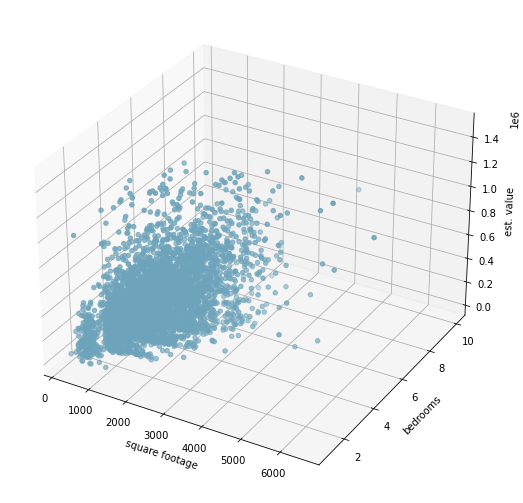

In [10]:
fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111, projection = '3d')

y = X_val['bedroomcnt']
x = X_val['finishedsqft']
z = y_val
ax.set_ylabel("bedrooms")
ax.set_xlabel("square footage")
ax.set_zlabel("est. value")
 
# plot the plane
#ax.plot_surface(x, y, z, alpha=0.5)
ax.scatter(x, y, z)
plt.show()

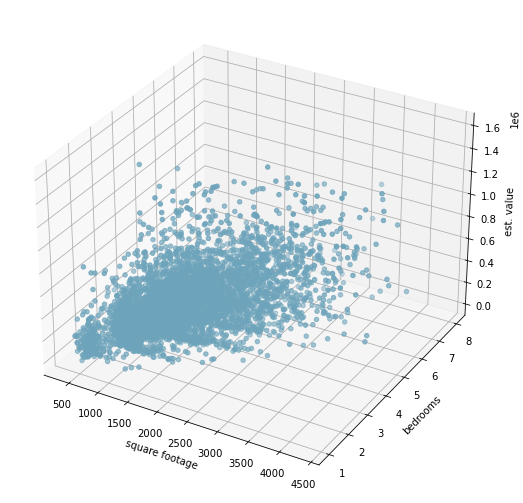

In [13]:
#%matplotlib widget
fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111, projection = '3d')

y = X_val['bedroomcnt']
x = X_val['finishedsqft']
z = y_val
ax.set_ylabel("bedrooms")
ax.set_xlabel("square footage")
ax.set_zlabel("est. value")
 
# plot the plane
#ax.plot_surface(x, y, z, alpha=0.5)
ax.scatter(x, y, z)

plt.show()

In [54]:
X_train = X_train.drop(['geometry'], axis=1)

KeyError: "['geometry'] not found in axis"

In [32]:
reg = make_pipeline(StandardScaler(), TweedieRegressor(power=2, alpha=2))
reg.fit(X_train, y_train)
y_pred = reg.predict(X_val)

print("Evaluating the Bad Model:")
print(f"  RMSE: {int(np.round(mean_squared_error(y_test, y_pred, squared=False),-3))}")
print(f"  MAPE: {np.round(mean_absolute_percentage_error(y_test, y_pred),2)}")
print(f"  R^2: {np.round(r2_score(y_test, y_pred),2)}")

Evaluating the Bad Model:
  RMSE: 274000
  MAPE: 0.94
  R^2: -0.09


## Garbaggio

In [4]:
X_train, X_test, X_val, y_train, y_test, y_val = wrangle_zillow(df, k=2.5) #k specifies outlier clipping

todrop = ['latitude', 'longitude', 'lotsqft', 'year', 'bedroomcnt',
          'buildingqualitytypeid', 'livingarearatio', 'regionidzip',
          'county', 'taxamount', 'landtaxvalue',
          'structuretaxvalue', 'taxrate'] #using zip codes for location

X_train = X_train.drop(todrop,axis=1)
X_val = X_val.drop(todrop, axis=1)
X_test = X_test.drop(todrop, axis=1)

X_train, X_test, X_val, y_train, y_test, y_val
(23857, 401) (5113, 401) (5113, 401) (23857,) (5113,) (5113,)


In [ ]:
xvars = ['latitude', 'longitude', 'bedroomcnt', 'bathroomcnt',
         'finishedsqft', 'lotsqft', 'year', 'livingarearatio']
reg = make_pipeline(StandardScaler(), LassoLars())
reg.fit(X_train[xvars], y_train)
y_pred = reg.predict(X_train[xvars])

print("Evaluating the Multilinear Model (in sample):")
print(f"  RMSE: {int(np.round(mean_squared_error(y_train, y_pred, squared=False),-3))}")
print(f"  MAPE: {np.round(mean_absolute_percentage_error(y_train, y_pred),2)}")
print(f"  R^2: {np.round(r2_score(y_train, y_pred),2)}")

y_pred = reg.predict(X_val[xvars])

print("Evaluating the Multilinear Model (out of sample):")
print(f"  RMSE: {int(np.round(mean_squared_error(y_val, y_pred, squared=False),-3))}")
print(f"  MAPE: {np.round(mean_absolute_percentage_error(y_val, y_pred),2)}")
print(f"  R^2: {np.round(r2_score(y_val, y_pred),2)}")

In [5]:
reg = make_pipeline(StandardScaler(), LassoLars())
reg.fit(X_train, y_train)
y_pred = reg.predict(X_train)

print("Evaluating the Garbage Bread Model (in sample):")
print(f"  RMSE: {int(np.round(mean_squared_error(y_train, y_pred, squared=False),-3))}")
print(f"  MAPE: {np.round(mean_absolute_percentage_error(y_train, y_pred),2)}")
print(f"  R^2: {np.round(r2_score(y_train, y_pred),2)}")

y_pred = reg.predict(X_val)

print("Evaluating the Garbage Bread Model (out of sample):")
print(f"  RMSE: {int(np.round(mean_squared_error(y_val, y_pred, squared=False),-3))}")
print(f"  MAPE: {np.round(mean_absolute_percentage_error(y_val, y_pred),2)}")
print(f"  R^2: {np.round(r2_score(y_val, y_pred),2)}")

Evaluating the Garbage Bread Model (in sample):
  RMSE: 196000
  MAPE: 0.69
  R^2: 0.41
Evaluating the Garbage Bread Model (out of sample):
  RMSE: 205000
  MAPE: 0.7
  R^2: 0.36


In [6]:
y_pred = reg.predict(X_test)

print("Evaluating the Final Model on test data:")
print(f"  RMSE: {int(np.round(mean_squared_error(y_test, y_pred, squared=False),-3))}")
print(f"  MAPE: {np.round(mean_absolute_percentage_error(y_test, y_pred),2)}")
print(f"  R^2: {np.round(r2_score(y_test, y_pred),2)}")

#baseline
y_pred = np.zeros((len(y_test),)) + y_train.mean() #make sure you use training mean!
print("Evaluating the Mean Model on test data:")
print(f"  RMSE: {int(np.round(mean_squared_error(y_test, y_pred, squared=False),-3))}")
print(f"  MAPE: {np.round(mean_absolute_percentage_error(y_test, y_pred),2)}")
print(f"  R^2: {np.round(r2_score(y_test, y_pred),2)}")

Evaluating the Final Model on test data:
  RMSE: 202000
  MAPE: 0.7
  R^2: 0.4
Evaluating the Mean Model on test data:
  RMSE: 262000
  MAPE: 0.94
  R^2: -0.0


In [52]:
pd.DataFrame(X_train.columns).to_csv("features.csv", index=False)

(array([ 81., 108.,  89.,  58.,  25.,  14.,   6.,   3.,   1.,   2.]),
 array([  1. ,  43.8,  86.6, 129.4, 172.2, 215. , 257.8, 300.6, 343.4,
        386.2, 429. ]),
 <BarContainer object of 10 artists>)

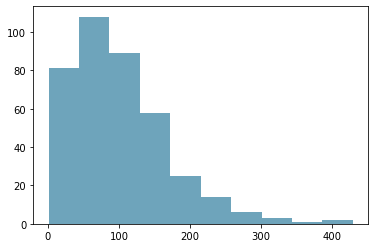

In [35]:
plt.hist(df.regionidzip.value_counts())

Takeaways

Precision of metrics:
Changing random state changed RMSE by a few thousand (all metrics by 1-2 percent)

Defining outliers makes a significant imact on model. Defining single-unit makes a noticable impact.

Mean percentage error is a good way to account for heteroskedasticity in data because it scales the error term proportionately.

Polynomial terms become impractical when the parmeter space is high. A neural network would be a better choice to increase model complexity.



In [ ]:
plt.figure(figsize=(16,8))
plt.plot(y_val.Total, y_val['mean'], alpha=.5, color="gray", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (16, 9.5))
plt.plot(y_val.Total, y_val.Total, alpha=.5, color="blue", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=15.5)

plt.scatter(y_val.Total, y_val.pred_lm, alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_val.Total, y_val.pred_glm, alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_val.Total, y_val.pred_lm2, alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Where are predictions more extreme?")
# plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
# plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()

In [ ]:
plt.figure(figsize=(16,8))
plt.axhline(label="No Error")
plt.scatter(y_val.Total, y_val.pred_lm-y_val.Total, alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_val.Total, y_val.pred_glm-y_val.Total, alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_val.Total, y_val.pred_lm2-y_val.Total, alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual")
plt.ylabel("Residual/Error: Predicted - Actual")
plt.title("Do the size of errors change as the actual value changes?")
plt.show()

In [ ]:
plt.figure(figsize=(16,8))
plt.hist(y_val.Total, color='blue', alpha=.5, label="Actual Final Grades")
plt.hist(y_val.pred_lm, color='red', alpha=.5, label="Model: LinearRegression")
plt.hist(y_val.pred_glm, color='yellow', alpha=.5, label="Model: TweedieRegressor")
plt.hist(y_val.pred_lm2, color='green', alpha=.5, label="Model 2nd degree Polynomial")
plt.xlabel("")
plt.ylabel("Number of Students")
plt.title("Comparing the Distribution of Actual to Distributions of Predicted for All Models")
plt.legend()
plt.show()